In [1]:
%pylab inline
import scanpy as sc
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## simulated pbmc

In [2]:
scf_adata = sc.read_h5ad('./data/cell_type_effector_memory_CD8_positive_alpha_beta_T_cell_id10_1038_s41591_021_01329_2_seed2022/scFoundation_bbknn_design.h5ad', backed=True)

In [3]:
scf_adata.obs['OOR_state_str']='out of refernece'
scf_adata.obs.loc[scf_adata.obs.OOR_state==0,'OOR_state_str']='in refernece'

In [4]:
sc.tl.umap(scf_adata)

In [5]:
sc.settings.figdir='./figure/'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

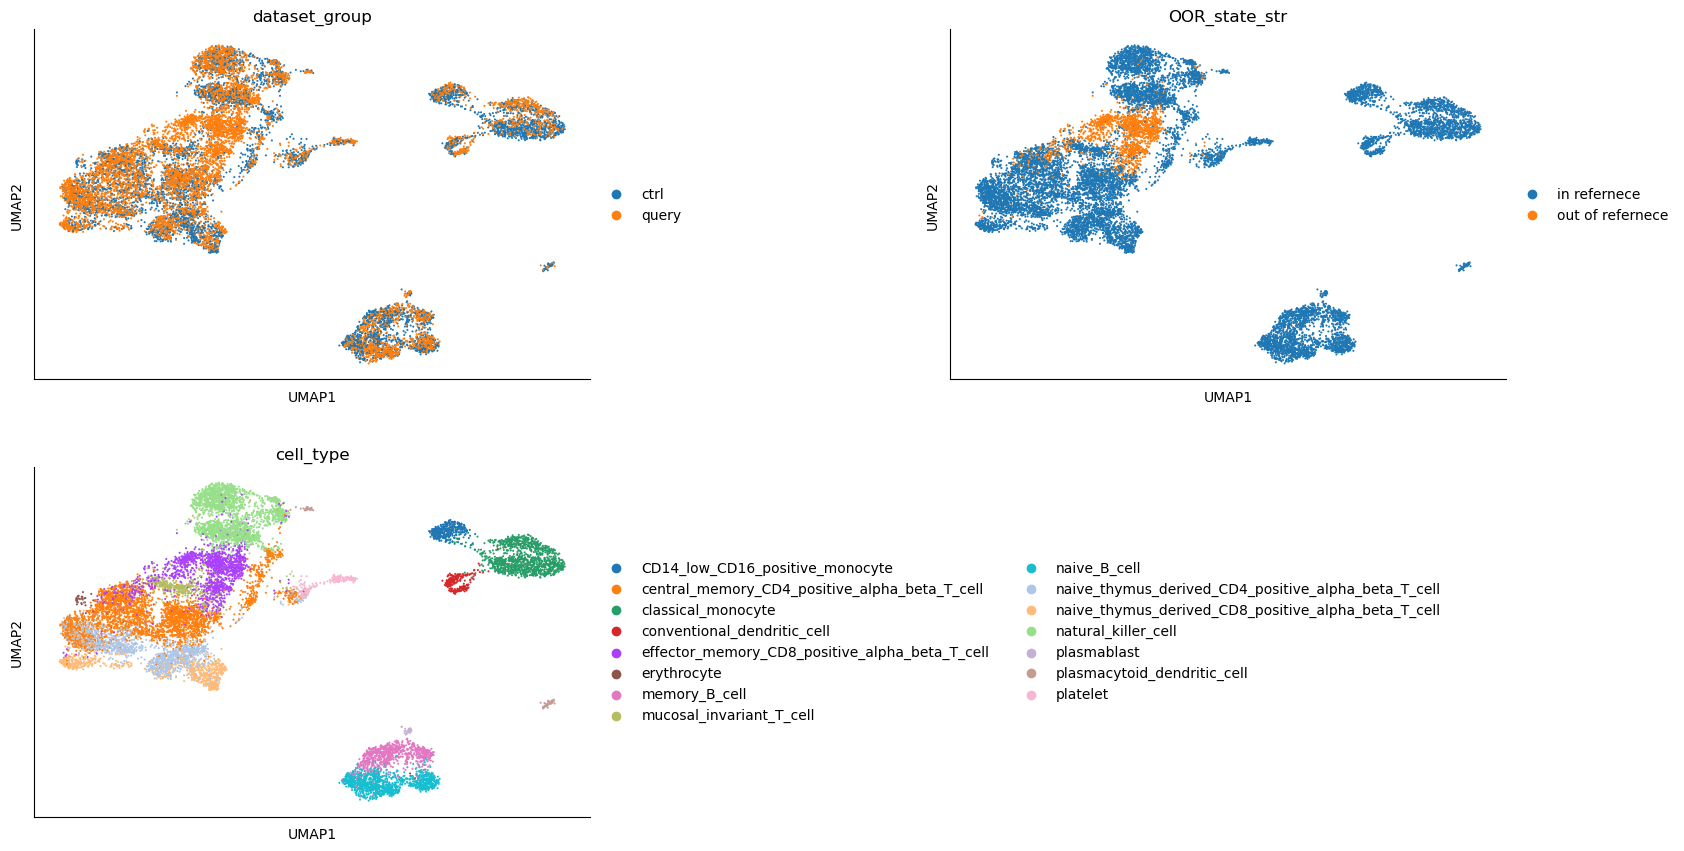

In [6]:
sc.pl.umap(scf_adata,color=['dataset_group','OOR_state_str','cell_type'],wspace=0.5,ncols=2,save='effector_memory_CD8_T_str',)

## organoid + in vivo

In [2]:
organoid = sc.read_h5ad('data/annotated_count_table/developed_human_retinal_organoid/scanpy_h5ad/adata_final_clean_organoid.h5ad')

In [3]:
fovea = sc.read_h5ad('data/annotated_count_table/adult_human_retina_normal_fovea/scanpy_h5ad/adata_final_clean_fovea.h5ad')

In [4]:
def subsample(adata,target_cells = 1000,cluster_key = 'cell_type_group'):
    adatas = [adata[adata.obs[cluster_key].isin([clust])] for clust in adata.obs[cluster_key].cat.categories]

    for dat in adatas:
        if dat.n_obs > target_cells:
             sc.pp.subsample(dat, n_obs=target_cells)

    adata_downsampled = adatas[0].concatenate(*adatas[1:])
    return adata_downsampled

In [5]:
organoid_downsampled = subsample(organoid)

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
fovea_downsampled = subsample(fovea)

/opt/conda/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [7]:
organoid_downsampled.obs['batch_id']='organoid'
fovea_downsampled.obs['batch_id']='foveal'

In [8]:
merged = sc.concat([organoid_downsampled,fovea_downsampled])

In [10]:
sc.pp.highly_variable_genes(merged)
sc.pp.scale(merged)
sc.pp.pca(merged)

In [11]:
sc.external.pp.bbknn(merged, batch_key='batch_id')  # running bbknn 1.3.6
sc.tl.umap(merged)

In [23]:
sc.settings.figdir="./figure/"
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

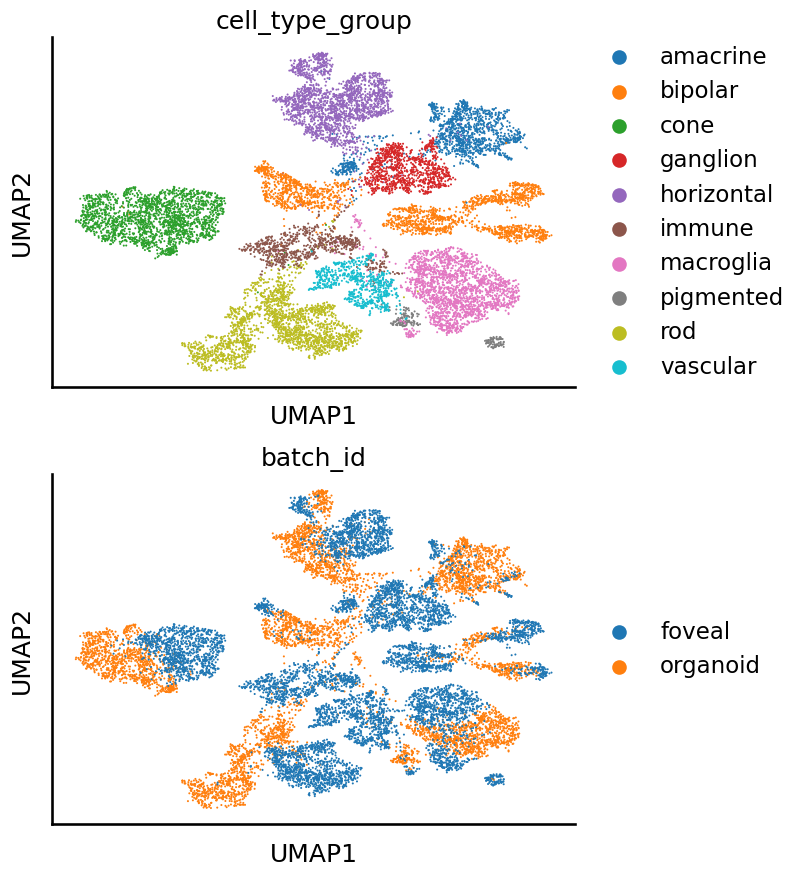

In [42]:
sc.pl.umap(merged,color=['cell_type_group','batch_id'],save='raw',ncols=1)

## to 19264

In [34]:
merged_count = pd.DataFrame(merged.raw.X.todense(),index = merged.obs_names,columns=merged.var_names)

In [36]:
def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    # to_fill = np.setdiff1d(gene_list, adata.var.index.values) # generate to fill list
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    #     df = pd.concat([X_df, padding_df], axis=1)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns,var
gene_list_df = pd.read_csv('../OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])

In [37]:
gexpr_feature, to_fill_columns,var = main_gene_selection(merged_count,gene_list)

In [44]:
gexpr_feature.to_csv('data/merged_count_19264.csv')

## get embedding

In [13]:
scfemb = np.load('./data/organoid_01B-resolution_singlecell_cell_embedding_t4.5_resolution.npy')

In [14]:
merged.obsm['scf']=scfemb

In [15]:
scfadata = merged.copy()

In [16]:
sc.external.pp.bbknn(scfadata, batch_key='batch_id',use_rep='scf',n_pcs=scfemb.shape[1])  # running bbknn 1.3.6
sc.tl.umap(scfadata)

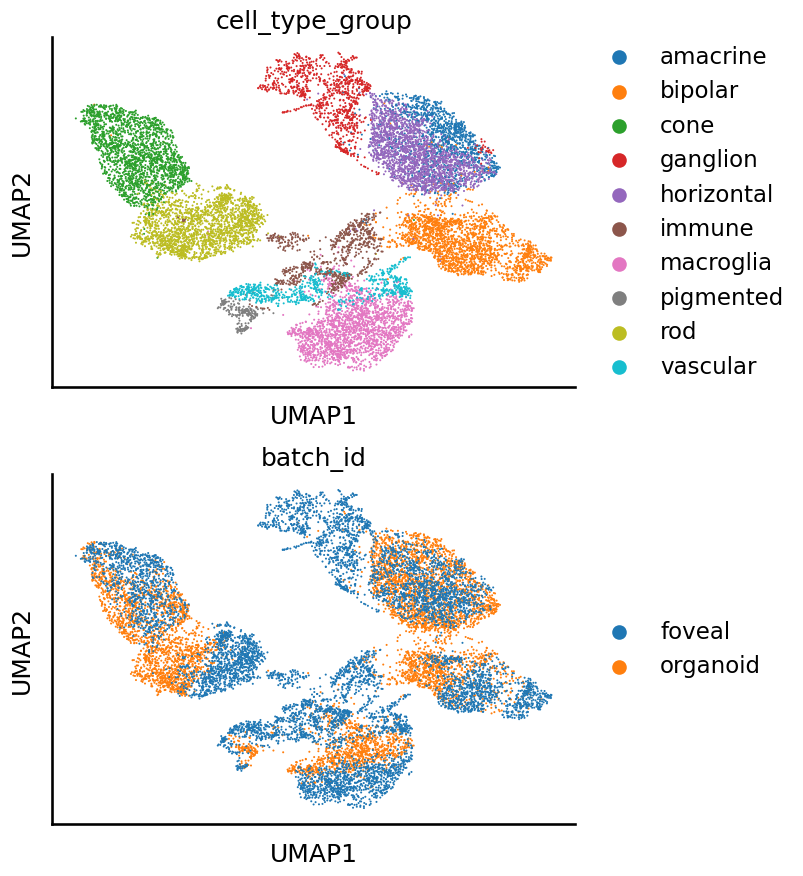

In [26]:
sc.pl.umap(scfadata,color=['cell_type_group','batch_id'],save='scfoundation',ncols=1)

In [18]:
import scib

In [20]:
scib.metrics.clisi_graph(merged,label_key='cell_type_group',type_='knn')

0.9999928599086453

In [19]:
scib.metrics.clisi_graph(scfadata,label_key='cell_type_group',type_='knn')

0.99420977616076

In [21]:
scib.metrics.ilisi_graph(merged,batch_key='batch_id',type_='knn')

0.7854932638127501

In [22]:
scib.metrics.ilisi_graph(scfadata,batch_key='batch_id',type_='knn')

0.9649820773586137

In [27]:
scfadata.write_h5ad('scfadata.h5ad')
merged.write_h5ad('merged.h5ad')

In [37]:
rawmerged = sc.concat([organoid_downsampled,fovea_downsampled])

In [39]:
rawmerged.write_h5ad('rawmerged.h5ad')

In [40]:
organoid_downsampled.write_h5ad('organoid_downsampled.h5ad')
fovea_downsampled.write_h5ad('fovea_downsampled.h5ad')

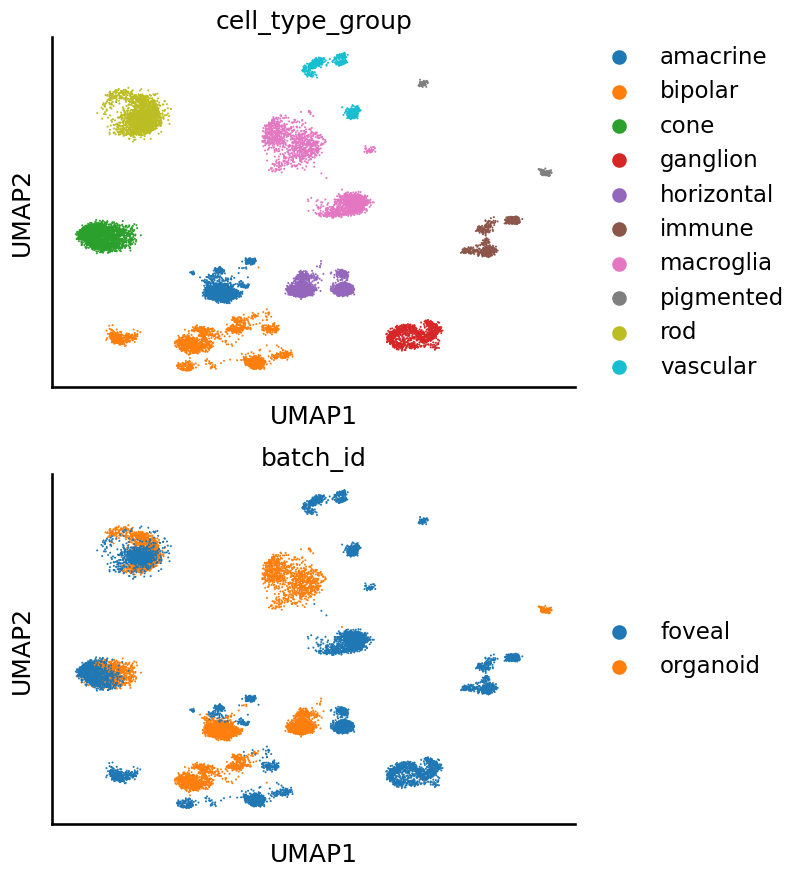

In [41]:
sc.pl.umap(rawmerged,color=['cell_type_group','batch_id'],ncols=1,save='scvi')

In [3]:
scbemb = np.load('../../../baseline/scBERT/organoid_embedding.npy')

In [4]:
merged = sc.read_h5ad('rawmerged.h5ad')

In [6]:
merged.obsm['scb']=scbemb

scbadata = merged.copy()

sc.external.pp.bbknn(scbadata, batch_key='batch_id',use_rep='scb',n_pcs=scbemb.shape[1])  # running bbknn 1.3.6

sc.tl.umap(scbadata)

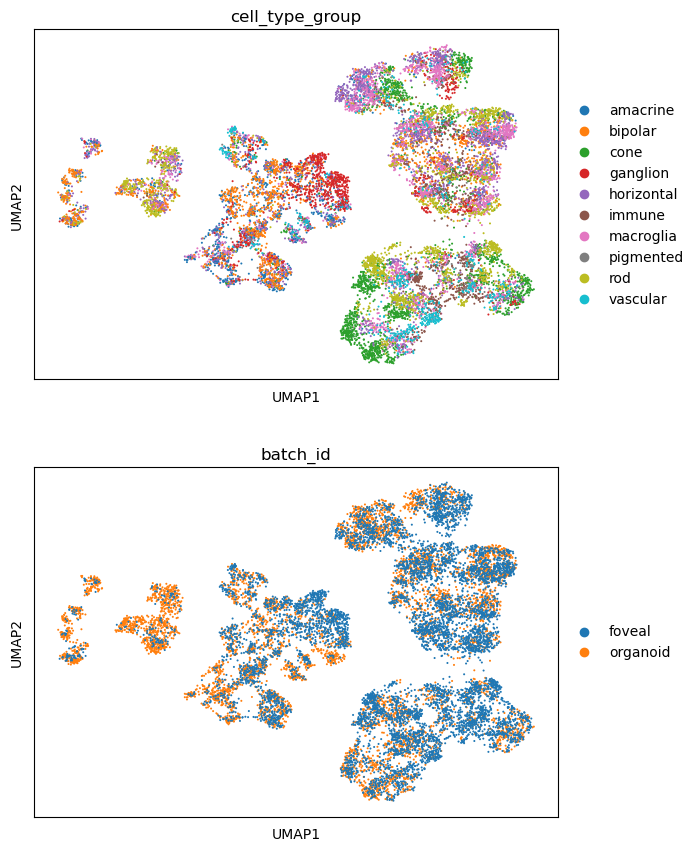

In [7]:
sc.pl.umap(scbadata,color=['cell_type_group','batch_id'],ncols=1,save='scBERT')

In [9]:
import scib
scib.metrics.clisi_graph(scbadata,label_key='cell_type_group',type_='knn')

0.7772571651724914

In [10]:
scib.metrics.ilisi_graph(scbadata,batch_key='batch_id',type_='knn')

0.9462220074970018